# Project
### Link to GitHub Repository

## Predicting Newsletter Subscription in a Minecraft Research Server

## Introduction

### Background

Understanding user behavior in video games is a growing area of interest for both researchers and developers. In this project, we analyze player data collected from a Minecraft research server to investigate which player characteristics and behaviors are predictive of subscribing to a game-related newsletter. This question is important because targeting players more likely to engage with the community can help optimize recruitment strategies and server resource allocation.

### Question

Can player characteristics such as experience level and total played hours predict newsletter subscription in the Minecraft dataset?


## Data Description

The dataset `players.csv` includes 196 unique players with the following variables:

- `subscribe` (factor): Whether the player subscribed to the newsletter.
- `experience` (categorical): Self-reported experience level in the game.
- `played_hours` (numeric): Total number of hours the player spent playing.


In [10]:
library(tidyverse)
library(tidymodels)

## Methods & Results

### Data Preparation

The `players.csv` dataset was loaded using `read_csv()`. The `experience` variable was converted into an ordered factor from “Beginner” to “Pro”, and `subscribe` was converted into a factor. A new dataset was created using only `subscribe` and `played_hours`.


In [11]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
experience_levels <- c("Beginner", "Amateur", "Regular", "Veteran", "Pro")

model_data <- players |>
  select(subscribe, experience, played_hours) |>
  mutate(subscribe = as.factor(subscribe),
         experience = factor(experience, levels = experience_levels))

head(model_data)

subscribe,experience,played_hours
<fct>,<fct>,<dbl>
TRUE,Pro,30.3
TRUE,Veteran,3.8
FALSE,Veteran,0.0
TRUE,Amateur,0.7
TRUE,Regular,0.1
TRUE,Amateur,0.0


In [14]:
model_data |>
  group_by(experience, subscribe) |>
  summarise(count = n()) |>
  pivot_wider(names_from = subscribe, values_from = count, values_fill = 0) |>
  rename(False = `FALSE`, True = `TRUE`)

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,False,True
<fct>,<int>,<int>
Beginner,8,27
Amateur,18,45
Regular,7,29
Veteran,15,33
Pro,4,10


### Exploratory Data Analysis

#### Figure 1: Proportion of Subscription Status by Experience Level

The bar chart below shows the proportion of players who subscribed and did not subscribe within each experience level. The chart shows that the influence of experience level on subscription is not very significant.
#### Figure 2: Played Hours by Subscription Status

The boxplot below compares the distribution of `played_hours` between subscribed and non-subscribed players. Subscribed players appear to have generally played more, with a higher median and more upper outliers.


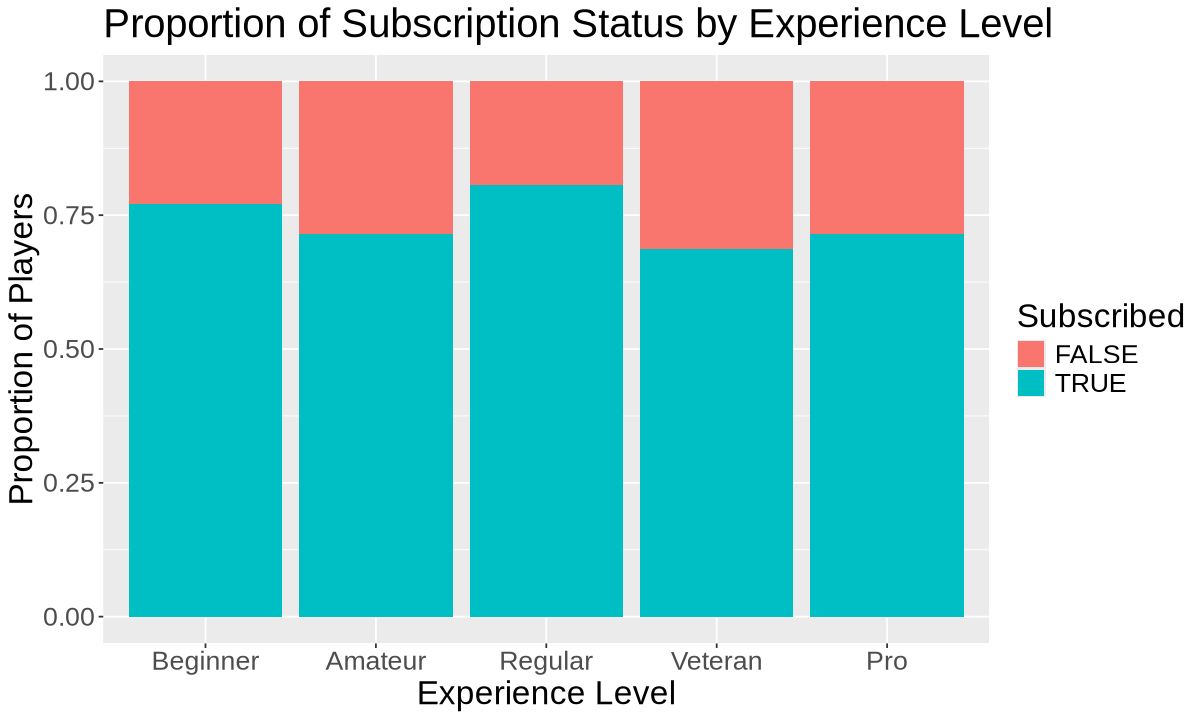

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)

experience_subscribe_counts <- model_data |>
  count(experience, subscribe)

experience_subscribe_counts |>
  ggplot(aes(x = experience, y = n, fill = subscribe)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(title = "Proportion of Subscription Status by Experience Level",
       x = "Experience Level",
       y = "Proportion of Players",
       fill = "Subscribed") +
       theme(text = element_text(size = 20))

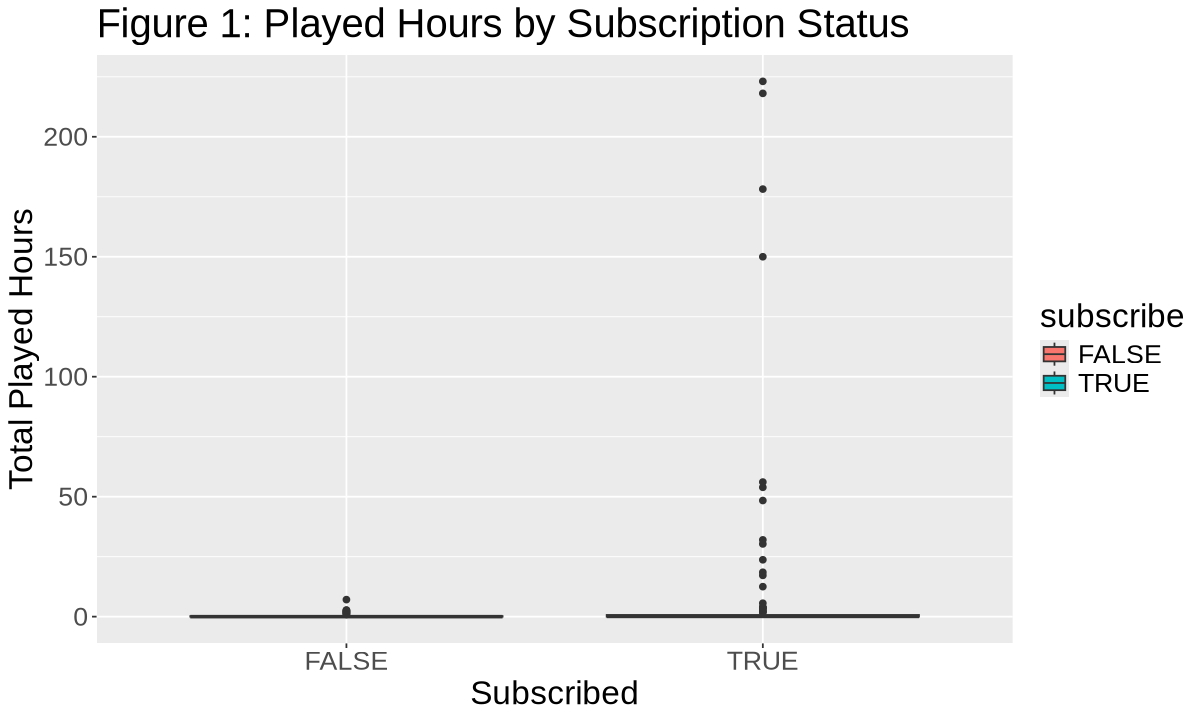

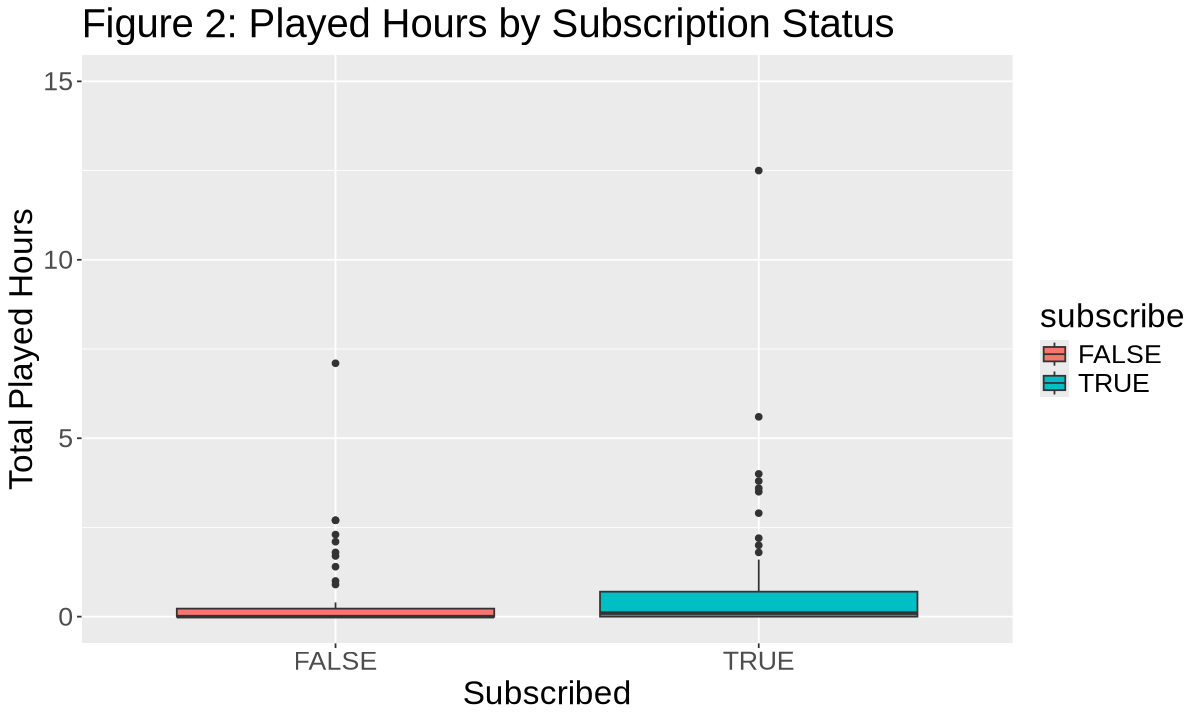

In [16]:
ggplot(model_data, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Figure 1: Played Hours by Subscription Status",
       x = "Subscribed",
       y = "Total Played Hours") +
  theme(text = element_text(size = 20))

ggplot(model_data, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot() +
  coord_cartesian(ylim = c(0, 15)) +
  labs(title = "Figure 2: Played Hours by Subscription Status",
       x = "Subscribed",
       y = "Total Played Hours") +
  theme(text = element_text(size = 20))

In [18]:
model_data_played <- model_data |>
  select(subscribe, played_hours)

set.seed(2025)
data_split <- initial_split(model_data_played, prop = 0.75, strata = subscribe)
data_train <- training(data_split)
data_test <- testing(data_split)

knn_recipe <- recipe(subscribe ~ played_hours, data = data_train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

knn_spec <- nearest_neighbor(neighbors = 5, weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = data_train)

knn_preds <- knn_fit |>
  predict(data_test) |>
  bind_cols(data_test)

knn_preds |>
 conf_mat(truth=subscribe, estimate =.pred_class)
knn_preds |>
 metrics(truth=subscribe, estimate =.pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     8   23
     TRUE      5   13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4285714
kap,binary,-0.0162963
